In [1]:
bool_optuna = False
debug = False

___
___
# **Librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import VotingRegressor

import xgboost as xgb
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier


#from catboost import CatBoostClassifier


from tqdm import tqdm
import time

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

___
___
# **Open Data**

In [3]:
data_path = "/kaggle/input/trustii-processed-data/"
data_path = "Data/"

In [4]:
df       = pd.read_csv(data_path + 'train.csv')
test_df  = pd.read_csv(data_path + 'test.csv')

if 'trustii_id' in df :
    df = df.drop(columns = ['trustii_id'])

print(df.shape, test_df.shape)
display(df.head())

(22671, 921) (9717, 922)


,APP_Libelle_etablissement,SIRET,Adresse_2_UA,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_type_activite,APP_Libelle_activite_etablissement_initial,Libelle_commune_initial,APP_Libelle_etablissement_initial,Adresse_2_UA_initial,trancheEffectifsEtablissement,activitePrincipaleRegistreMetiersEtablissement,etablissementSiege,nombrePeriodesEtablissement,indiceRepetitionEtablissement,codeCommuneEtablissement,codeCedexEtablissement,activitePrincipaleEtablissement,caractereEmployeurEtablissement,codeCedexEtablissement_2char,codeCommuneEtablissement_2char,Diffdate_days_DateInspection_dateDebut,Diffdate_days_DateInspection_dateCreationEtablissement,year_dateDebut,month_dateDebut,year_dateCreationEtablissement,month_dateCreationEtablissement,Code_NAF_1,Code_NAF_2,Egalite_NAF,tfidf_abattoir,tfidf_accueil,tfidf_agricole,tfidf_andre,tfidf_arc,tfidf_ass,tfidf_association,tfidf_atelier,tfidf_auberge,tfidf_auchan,tfidf_bar,tfidf_bat,tfidf_belle,tfidf_bio,tfidf_bistrot,tfidf_bois,tfidf_bon,tfidf_boucherie,tfidf_boulangerie,tfidf_brasserie,tfidf_burger,tfidf_cafe,tfidf_cantine,tfidf_carrefour,tfidf_centrale,tfidf_centre,tfidf_charcuterie,tfidf_chateau,tfidf_chez,tfidf_chicken,tfidf_city,tfidf_clinique,tfidf_co,tfidf_college,tfidf_commune,tfidf_compagnie,tfidf_comptoir,tfidf_coop,tfidf_cooperative,tfidf_cote,tfidf_creche,tfidf_creperie,tfidf_cuisine,tfidf_dame,tfidf_delices,tfidf_di,tfidf_distribution,tfidf_domaine,tfidf_donald,tfidf_earl,tfidf_ecole,tfidf_ehpad,tfidf_elementaire,tfidf_enfance,tfidf_epicerie,tfidf_esat,tfidf_etablissements,tfidf_ets,tfidf_eurl,tfidf_exploitation,tfidf_express,tfidf_ferme,tfidf_fils,tfidf_fondation,tfidf_food,tfidf_fournil,tfidf_foyer,tfidf_france,tfidf_francois,tfidf_franprix,tfidf_freres,tfidf_fromagerie,tfidf_gaec,tfidf_gestion,tfidf_gourmand,tfidf_gourmet,tfidf_grand,tfidf_grill,tfidf_groupe,tfidf_hopital,tfidf_hospitalier,tfidf_hotel,tfidf_huitres,tfidf_intermarche,tfidf_jardins,tfidf_jean,tfidf_joseph,tfidf_kebab,tfidf_king,tfidf_leclerc,tfidf_louis,tfidf_lycee,tfidf_mairie,tfidf_maison,tfidf_marche,tfidf_maree,tfidf_marie,tfidf_market,tfidf_mas,tfidf_maternelle,tfidf_mer,tfidf_metro,tfidf_michel,tfidf_moulin,tfidf_nouvelle,tfidf_ogec,tfidf_pain,tfidf_palais,tfidf_parc,tfidf_paris,tfidf_paul,tfidf_pays,tfidf_petit,tfidf_petite,tfidf_petits,tfidf_philippe,tfidf_pierre,tfidf_pizza,tfidf_poissonnerie,tfidf_primaire,tfidf_professionnel,tfidf_publique,tfidf_relais,tfidf_residence,tfidf_restaurant,tfidf_restauration,tfidf_retraite,tfidf_royal,tfidf_saint,tfidf_salaisons,tfidf_sarl,tfidf_sas,tfidf_saveurs,tfidf_scea,tfidf_scolaire,tfidf_snack,tfidf_soc,tfidf_ste,tfidf_sud,tfidf_super,tfidf_supermarche,tfidf_sushi,tfidf_table,tfidf_tacos,tfidf_traiteur,tfidf_val,tfidf_viande,tfidf_viandes,tfidf_volailles,tfidf_wok,tfidf_adresse_avenue,tfidf_adresse_boulevard,tfidf_adresse_che,tfidf_adresse_chemin,tfidf_adresse_gaulle,tfidf_adresse_general,tfidf_adresse_jean,tfidf_adresse_nan,tfidf_adresse_pierre,tfidf_adresse_place,tfidf_adresse_quai,tfidf_adresse_route,tfidf_adresse_rue,tfidf_adresse_saint,tfidf_adresse_zone,Ville,Departement,flag_Abattage de produits de l'aquaculture,flag_Alimentation générale,flag_Autres activités de remise directe,flag_Boucherie-Charcuterie,flag_Boulangerie-Pâtisserie,flag_Caves d'affinage,flag_Centre d'emballage des oeufs,flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage,flag_Chaîne d'abattage de volaille/lagomorphe/petit gibier,flag_Chocolatier,flag_Collecte de gibier sauvage,flag_Collecte de lait,flag_Collecte et transformation de miel,flag_Collecteur d'oeufs,flag_Commerce alimentaire,flag_Distribution automatique,flag_Découpe de fromages,flag_Découpe de gibier sauvage,flag_Découpe de gros gibier d'élevage,flag_Découpe de produits de charcuterie,flag_Découpe de viande de boucherie,flag_Découpe de viandes de volailles/lagomorphe,flag_Déshydratation de lait ou produits laitiers,flag

In [5]:
if debug :
    print("DEBUG IS ON ! ")
    df = df.sample(n = 500, random_state=12).reset_index(drop=True)
    
print(df.shape)

(22671, 921)


In [6]:
df['Synthese_eval_sanit'].value_counts()

Synthese_eval_sanit
Satisfaisant                     13009
Très satisfaisant                 8226
A améliorer                       1327
A corriger de manière urgente      109
Name: count, dtype: int64

In [7]:
dico_y = {'A corriger de manière urgente' : 0,
          'A améliorer' : 1,
          'Satisfaisant' : 2,
          'Très satisfaisant' : 3,
         }
dico_y_INVERSE = {v:k for k, v in dico_y.items()}

In [8]:
print(df.shape, test_df.shape)

(22671, 921) (9717, 922)


In [9]:
df['y'] = df['Synthese_eval_sanit'].map(dico_y)

___
___
# **Modelisation**

In [11]:
df = df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df.head(2)

,APP_Libelle_etablissement,SIRET,Adresse_2_UA,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_type_activite,APP_Libelle_activite_etablissement_initial,Libelle_commune_initial,APP_Libelle_etablissement_initial,Adresse_2_UA_initial,trancheEffectifsEtablissement,activitePrincipaleRegistreMetiersEtablissement,etablissementSiege,nombrePeriodesEtablissement,indiceRepetitionEtablissement,codeCommuneEtablissement,codeCedexEtablissement,activitePrincipaleEtablissement,caractereEmployeurEtablissement,codeCedexEtablissement_2char,codeCommuneEtablissement_2char,Diffdate_days_DateInspection_dateDebut,Diffdate_days_DateInspection_dateCreationEtablissement,year_dateDebut,month_dateDebut,year_dateCreationEtablissement,month_dateCreationEtablissement,Code_NAF_1,Code_NAF_2,Egalite_NAF,tfidf_abattoir,tfidf_accueil,tfidf_agricole,tfidf_andre,tfidf_arc,tfidf_ass,tfidf_association,tfidf_atelier,tfidf_auberge,tfidf_auchan,tfidf_bar,tfidf_bat,tfidf_belle,tfidf_bio,tfidf_bistrot,tfidf_bois,tfidf_bon,tfidf_boucherie,tfidf_boulangerie,tfidf_brasserie,tfidf_burger,tfidf_cafe,tfidf_cantine,tfidf_carrefour,tfidf_centrale,tfidf_centre,tfidf_charcuterie,tfidf_chateau,tfidf_chez,tfidf_chicken,tfidf_city,tfidf_clinique,tfidf_co,tfidf_college,tfidf_commune,tfidf_compagnie,tfidf_comptoir,tfidf_coop,tfidf_cooperative,tfidf_cote,tfidf_creche,tfidf_creperie,tfidf_cuisine,tfidf_dame,tfidf_delices,tfidf_di,tfidf_distribution,tfidf_domaine,tfidf_donald,tfidf_earl,tfidf_ecole,tfidf_ehpad,tfidf_elementaire,tfidf_enfance,tfidf_epicerie,tfidf_esat,tfidf_etablissements,tfidf_ets,tfidf_eurl,tfidf_exploitation,tfidf_express,tfidf_ferme,tfidf_fils,tfidf_fondation,tfidf_food,tfidf_fournil,tfidf_foyer,tfidf_france,tfidf_francois,tfidf_franprix,tfidf_freres,tfidf_fromagerie,tfidf_gaec,tfidf_gestion,tfidf_gourmand,tfidf_gourmet,tfidf_grand,tfidf_grill,tfidf_groupe,tfidf_hopital,tfidf_hospitalier,tfidf_hotel,tfidf_huitres,tfidf_intermarche,tfidf_jardins,tfidf_jean,tfidf_joseph,tfidf_kebab,tfidf_king,tfidf_leclerc,tfidf_louis,tfidf_lycee,tfidf_mairie,tfidf_maison,tfidf_marche,tfidf_maree,tfidf_marie,tfidf_market,tfidf_mas,tfidf_maternelle,tfidf_mer,tfidf_metro,tfidf_michel,tfidf_moulin,tfidf_nouvelle,tfidf_ogec,tfidf_pain,tfidf_palais,tfidf_parc,tfidf_paris,tfidf_paul,tfidf_pays,tfidf_petit,tfidf_petite,tfidf_petits,tfidf_philippe,tfidf_pierre,tfidf_pizza,tfidf_poissonnerie,tfidf_primaire,tfidf_professionnel,tfidf_publique,tfidf_relais,tfidf_residence,tfidf_restaurant,tfidf_restauration,tfidf_retraite,tfidf_royal,tfidf_saint,tfidf_salaisons,tfidf_sarl,tfidf_sas,tfidf_saveurs,tfidf_scea,tfidf_scolaire,tfidf_snack,tfidf_soc,tfidf_ste,tfidf_sud,tfidf_super,tfidf_supermarche,tfidf_sushi,tfidf_table,tfidf_tacos,tfidf_traiteur,tfidf_val,tfidf_viande,tfidf_viandes,tfidf_volailles,tfidf_wok,tfidf_adresse_avenue,tfidf_adresse_boulevard,tfidf_adresse_che,tfidf_adresse_chemin,tfidf_adresse_gaulle,tfidf_adresse_general,tfidf_adresse_jean,tfidf_adresse_nan,tfidf_adresse_pierre,tfidf_adresse_place,tfidf_adresse_quai,tfidf_adresse_route,tfidf_adresse_rue,tfidf_adresse_saint,tfidf_adresse_zone,Ville,Departement,flag_Abattage de produits de l'aquaculture,flag_Alimentation générale,flag_Autres activités de remise directe,flag_Boucherie-Charcuterie,flag_Boulangerie-Pâtisserie,flag_Caves d'affinage,flag_Centre d'emballage des oeufs,flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage,flag_Chaîne d'abattage de volaille/lagomorphe/petit gibier,flag_Chocolatier,flag_Collecte de gibier sauvage,flag_Collecte de lait,flag_Collecte et transformation de miel,flag_Collecteur d'oeufs,flag_Commerce alimentaire,flag_Distribution automatique,flag_Découpe de fromages,flag_Découpe de gibier sauvage,flag_Découpe de gros gibier d'élevage,flag_Découpe de produits de charcuterie,flag_Découpe de viande de boucherie,flag_Découpe de viandes de volailles/lagomorphe,flag_Déshydratation de lait ou produits laitiers,flag

In [12]:
useless = [
          ]

print(len(useless))

0


In [13]:
forbidden = ['APP_Libelle_etablissement',
             'APP_Libelle_etablissement_initial',
             'APP_Libelle_activite_etablissement_initial',
             'Libelle_commune_initial',
             'Numero_inspection_milieu2',
             'Numero_inspection_milieu3',
             'Numero_inspection_milieu_all',
             'SIRET',
             'Adresse_2_UA',
             'Adresse_2_UA_initial',
             'Code_postal',
             'Numero_inspection',
             'Date_inspection',
             'Synthese_eval_sanit',
             'Agrement',
             'geores',
             'y',
            ]

feats = [x for x in df if x not in forbidden and x not in useless and not(any(s in x for s in ['oof', '_y_', '_y']))]

print(len(feats))
df[feats].head()

892


,Libelle_commune,APP_Libelle_activite_etablissement,filtre,ods_type_activite,trancheEffectifsEtablissement,activitePrincipaleRegistreMetiersEtablissement,etablissementSiege,nombrePeriodesEtablissement,indiceRepetitionEtablissement,codeCommuneEtablissement,codeCedexEtablissement,activitePrincipaleEtablissement,caractereEmployeurEtablissement,codeCedexEtablissement_2char,codeCommuneEtablissement_2char,Diffdate_days_DateInspection_dateDebut,Diffdate_days_DateInspection_dateCreationEtablissement,year_dateDebut,month_dateDebut,year_dateCreationEtablissement,month_dateCreationEtablissement,Code_NAF_1,Code_NAF_2,Egalite_NAF,tfidf_abattoir,tfidf_accueil,tfidf_agricole,tfidf_andre,tfidf_arc,tfidf_ass,tfidf_association,tfidf_atelier,tfidf_auberge,tfidf_auchan,tfidf_bar,tfidf_bat,tfidf_belle,tfidf_bio,tfidf_bistrot,tfidf_bois,tfidf_bon,tfidf_boucherie,tfidf_boulangerie,tfidf_brasserie,tfidf_burger,tfidf_cafe,tfidf_cantine,tfidf_carrefour,tfidf_centrale,tfidf_centre,tfidf_charcuterie,tfidf_chateau,tfidf_chez,tfidf_chicken,tfidf_city,tfidf_clinique,tfidf_co,tfidf_college,tfidf_commune,tfidf_compagnie,tfidf_comptoir,tfidf_coop,tfidf_cooperative,tfidf_cote,tfidf_creche,tfidf_creperie,tfidf_cuisine,tfidf_dame,tfidf_delices,tfidf_di,tfidf_distribution,tfidf_domaine,tfidf_donald,tfidf_earl,tfidf_ecole,tfidf_ehpad,tfidf_elementaire,tfidf_enfance,tfidf_epicerie,tfidf_esat,tfidf_etablissements,tfidf_ets,tfidf_eurl,tfidf_exploitation,tfidf_express,tfidf_ferme,tfidf_fils,tfidf_fondation,tfidf_food,tfidf_fournil,tfidf_foyer,tfidf_france,tfidf_francois,tfidf_franprix,tfidf_freres,tfidf_fromagerie,tfidf_gaec,tfidf_gestion,tfidf_gourmand,tfidf_gourmet,tfidf_grand,tfidf_grill,tfidf_groupe,tfidf_hopital,tfidf_hospitalier,tfidf_hotel,tfidf_huitres,tfidf_intermarche,tfidf_jardins,tfidf_jean,tfidf_joseph,tfidf_kebab,tfidf_king,tfidf_leclerc,tfidf_louis,tfidf_lycee,tfidf_mairie,tfidf_maison,tfidf_marche,tfidf_maree,tfidf_marie,tfidf_market,tfidf_mas,tfidf_maternelle,tfidf_mer,tfidf_metro,tfidf_michel,tfidf_moulin,tfidf_nouvelle,tfidf_ogec,tfidf_pain,tfidf_palais,tfidf_parc,tfidf_paris,tfidf_paul,tfidf_pays,tfidf_petit,tfidf_petite,tfidf_petits,tfidf_philippe,tfidf_pierre,tfidf_pizza,tfidf_poissonnerie,tfidf_primaire,tfidf_professionnel,tfidf_publique,tfidf_relais,tfidf_residence,tfidf_restaurant,tfidf_restauration,tfidf_retraite,tfidf_royal,tfidf_saint,tfidf_salaisons,tfidf_sarl,tfidf_sas,tfidf_saveurs,tfidf_scea,tfidf_scolaire,tfidf_snack,tfidf_soc,tfidf_ste,tfidf_sud,tfidf_super,tfidf_supermarche,tfidf_sushi,tfidf_table,tfidf_tacos,tfidf_traiteur,tfidf_val,tfidf_viande,tfidf_viandes,tfidf_volailles,tfidf_wok,tfidf_adresse_avenue,tfidf_adresse_boulevard,tfidf_adresse_che,tfidf_adresse_chemin,tfidf_adresse_gaulle,tfidf_adresse_general,tfidf_adresse_jean,tfidf_adresse_nan,tfidf_adresse_pierre,tfidf_adresse_place,tfidf_adresse_quai,tfidf_adresse_route,tfidf_adresse_rue,tfidf_adresse_saint,tfidf_adresse_zone,Ville,Departement,flag_Abattage de produits de l'aquaculture,flag_Alimentation générale,flag_Autres activités de remise directe,flag_Boucherie-Charcuterie,flag_Boulangerie-Pâtisserie,flag_Caves d'affinage,flag_Centre d'emballage des oeufs,flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage,flag_Chaîne d'abattage de volaille/lagomorphe/petit gibier,flag_Chocolatier,flag_Collecte de gibier sauvage,flag_Collecte de lait,flag_Collecte et transformation de miel,flag_Collecteur d'oeufs,flag_Commerce alimentaire,flag_Distribution automatique,flag_Découpe de fromages,flag_Découpe de gibier sauvage,flag_Découpe de gros gibier d'élevage,flag_Découpe de produits de charcuterie,flag_Découpe de viande de boucherie,flag_Découpe de viandes de volailles/lagomorphe,flag_Déshydratation de lait ou produits laitiers,flag_Elevage de bovins,flag_Entreposage de distribution de denrées alimentaires,flag_Entreposage de produits de la pêche,flag_Entreposage de produits laitiers,flag_Entreposage de viande de boucherie,flag_Entreposage de viande de volailles,flag_Entreposa

In [14]:
feats = ['Libelle_commune',
 'APP_Libelle_activite_etablissement',
 'filtre',
 'ods_type_activite',
 'etablissementSiege',
 'codeCommuneEtablissement',
 'activitePrincipaleEtablissement',
 'codeCommuneEtablissement_2char',
 'Code_NAF_1',
 'Code_NAF_2',
 'Egalite_NAF',
 'tfidf_ass',
 'tfidf_atelier',
 'tfidf_bistrot',
 'tfidf_boucherie',
 'tfidf_centre',
 'tfidf_charcuterie',
 'tfidf_chateau',
 'tfidf_college',
 'tfidf_commune',
 'tfidf_delices',
 'tfidf_donald',
 'tfidf_earl',
 'tfidf_ecole',
 'tfidf_ehpad',
 'tfidf_etablissements',
 'tfidf_eurl',
 'tfidf_exploitation',
 'tfidf_fils',
 'tfidf_gaec',
 'tfidf_groupe',
 'tfidf_king',
 'tfidf_leclerc',
 'tfidf_mairie',
 'tfidf_maree',
 'tfidf_market',
 'tfidf_mas',
 'tfidf_pain',
 'tfidf_paris',
 'tfidf_saint',
 'tfidf_salaisons',
 'tfidf_sarl',
 'tfidf_saveurs',
 'tfidf_soc',
 'tfidf_sushi',
 'tfidf_viandes',
 'tfidf_adresse_pierre',
 'tfidf_adresse_saint',
 'Ville',
 'Departement',
 'flag_Autres activités de remise directe',
 'flag_Boulangerie-Pâtisserie',
 "flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage",
 'flag_Entreposage de distribution de denrées alimentaires',
 'flag_Métier de bouche',
 'flag_Producteur fermier',
 'flag_Rayon poissonnerie',
 'flag_Restauration collective',
 'flag_Transformation de lait ou produits laitiers',
 'flag_Transport de denrées alimentaires',
 #'Agrement_num_commune',
 'Agrement_num_entreprise',
 'Numero_inspection_len',
 'Numero_inspection_debut',
 'Numero_inspection_fin',
 'year',
 'dayofyear',
 'is_restaurant',
 'is_vendeur',
 'is_rayon',
 'is_boucherie',
 'missing_agrement',
         
 'other_y0_AGREMENTS_in_dftrain',
 'other_y1_AGREMENTS_in_dftrain',
 'other_y2_AGREMENTS_in_dftrain',
 'other_y3_AGREMENTS_in_dftrain',
 'N_agrements_in_train',
         
 'ndays_since_last_control',
 'ndays_since_older_control',
 'ndays_before_next_control',
 'ndays_before_furthest_control',
 'result_last_control',
 'result_older_control',
 'result_next_control',
 'result_furthest_control',
 'N_agrements_in_train_other_day',
 'N_agrements_in_train_past',
 'N_agrements_in_train_future',
 'ndays_MEAN_since_past_controls',
 'ndays_STD_since_past_controls',
 'ndays_MEAN_before_futur_controls',
 'ndays_STD_before_futur_controls',
         
 'Diffdate_days_DateInspection_dateDebut',
 'Diffdate_days_DateInspection_dateCreationEtablissement',
 
 'y_last_1th_control',
 'latitude',
 'longitude',
 'Days_since_next_control_to_REAL_3th_nearest',
 'Days_since_next_control_to_REAL_6th_nearest',
 'Days_since_next_control_to_REAL_10th_nearest',
 'Days_since_next_control_to_REAL_15th_nearest',
 'Days_since_next_control_to_REAL_20th_nearest',
 'MAX_dist_to_REAL_50th_nearest',
 'Days_since_next_control_to_3th_nearest_LibAct',
 'Days_since_next_control_to_6th_nearest_LibAct',
 'Days_since_next_control_to_10th_nearest_filtre',
 'MEAN_dist_to_20th_nearest_filtre',
 'MAX_dist_to_20th_nearest_filtre',
 'Days_since_next_control_to_20th_nearest_filtre',
 'MEAN_dist_to_3th_nearest_ods',
 'Days_since_next_control_to_3th_nearest_ods',
 'MAX_dist_to_6th_nearest_ods',
 'Days_since_next_control_to_6th_nearest_ods',
 'MEAN_dist_to_10th_nearest_ods',
 'MAX_dist_to_10th_nearest_ods',
 'Days_since_next_control_to_10th_nearest_ods',
 'MEAN_dist_to_20th_nearest_ods',
 'MAX_dist_to_20th_nearest_ods',
 'Days_since_next_control_to_20th_nearest_ods',
 'Days_since_nearest_control_to_20th_nearest_ods',
 'Days_since_next_control_to_3th_nearest_NAF1',
 'Days_since_next_control_to_6th_nearest_NAF1',
 'Days_since_next_control_to_10th_nearest_NAF1',
 'MEAN_dist_to_20th_nearest_NAF1',
 'STD_dist_to_20th_nearest_NAF1',
 'MAX_dist_to_20th_nearest_NAF1',
 'Days_since_next_control_to_20th_nearest_NAF1',
 'Days_since_next_control_to_3th_nearest_actPrincipal',
 'Days_since_next_control_to_20th_nearest_actPrincipal',
 'N_targets_1_within_0.03km',
 'N_targets_2_within_0.03km',
 'N_targets_3_within_0.03km',
 'N_NAF1_3_within_0.03km',
 'N_controls_same_day_within_0.03km',
 'N_POI_within_0.05km',
 'N_targets_1_within_0.05km',
 'N_targets_2_within_0.05km',
 'N_targets_3_within_0.05km',
 'N_NAF1_0_within_0.05km',
 'N_targets_1_within_0.075km',
 'N_targets_2_within_0.075km',
 'N_targets_3_within_0.075km',
 'N_NAF1_0_within_0.075km',
 'N_targets_1_within_0.1km',
 'N_targets_2_within_0.1km',
 'N_targets_3_within_0.1km',
 'N_NAF1_0_within_0.1km',
 'N_NAF1_1_within_0.1km',
 'N_NAF1_2_within_0.1km',
 'N_NAF1_5_within_0.1km',
 'N_POI_within_0.15km',
 'N_targets_1_within_0.15km',
 'N_targets_2_within_0.15km',
 'N_targets_3_within_0.15km',
 'N_NAF1_0_within_0.15km',
 'N_NAF1_2_within_0.15km',
 'N_POI_within_0.3km',
 'MEAN_dist_POI_within_0.3km',
 'N_targets_1_within_0.3km',
 'N_targets_2_within_0.3km',
 'N_targets_3_within_0.3km',
 'N_NAF1_0_within_0.3km',
 'N_NAF1_1_within_0.3km',
 'N_NAF1_2_within_0.3km',
 'N_NAF1_3_within_0.3km',
 'N_NAF1_4_within_0.3km',
 'N_POI_within_0.6km',
 'STD_dist_POI_within_0.6km',
 'N_targets_1_within_0.6km',
 'N_targets_2_within_0.6km',
 'N_targets_3_within_0.6km',
 'N_NAF1_0_within_0.6km',
 'N_NAF1_1_within_0.6km',
 'N_NAF1_2_within_0.6km',
 'N_NAF1_3_within_0.6km',
 'N_NAF1_4_within_0.6km',
 'N_NAF1_5_within_0.6km',
 'N_NAF1_6_within_0.6km',
 'N_controls_within_100days_and_0.6km',
 'N_POI_within_1km',
 'MEAN_dist_POI_within_1km',
 'STD_dist_POI_within_1km',
 'N_targets_0_within_1km',
 'N_targets_1_within_1km',
 'N_targets_2_within_1km',
 'N_targets_3_within_1km',
 'N_NAF1_0_within_1km',
 'N_NAF1_1_within_1km',
 'N_NAF1_2_within_1km',
 'N_NAF1_3_within_1km',
 'N_NAF1_4_within_1km',
 'N_NAF1_5_within_1km',
 'N_NAF1_6_within_1km',
 'N_controls_within_100days_and_1km',
 'N_POI_within_1.5km',
 'MEAN_dist_POI_within_1.5km',
 'STD_dist_POI_within_1.5km',
 'N_targets_0_within_1.5km',
 'N_targets_1_within_1.5km',
 'N_targets_2_within_1.5km',
 'N_targets_3_within_1.5km',
 'N_NAF1_0_within_1.5km',
 'N_NAF1_1_within_1.5km',
 'N_NAF1_2_within_1.5km',
 'N_NAF1_3_within_1.5km',
 'N_NAF1_4_within_1.5km',
 'N_NAF1_5_within_1.5km',
 'N_NAF1_6_within_1.5km',
 'N_controls_within_100days_and_1.5km',
 'N_controls_within_100daysPOS_and_1.5km',
 'N_controls_within_100daysNEG_and_1.5km',
 'N_POI_within_2km',
 'MEAN_dist_POI_within_2km',
 'STD_dist_POI_within_2km',
 'N_targets_0_within_2km',
 'N_targets_1_within_2km',
 'N_targets_2_within_2km',
 'N_targets_3_within_2km',
 'N_NAF1_0_within_2km',
 'N_NAF1_1_within_2km',
 'N_NAF1_2_within_2km',
 'N_NAF1_3_within_2km',
 'N_NAF1_4_within_2km',
 'N_NAF1_5_within_2km',
 'N_NAF1_6_within_2km',
 'N_controls_within_31days_and_2km',
 'N_controls_within_61days_and_2km',
 'N_controls_within_61daysNEG_and_2km',
 'N_controls_within_100days_and_2km',
 'N_controls_within_100daysPOS_and_2km',
 'N_controls_within_100daysNEG_and_2km',
 'N_POI_within_4km',
 'MEAN_dist_POI_within_4km',
 'STD_dist_POI_within_4km',
 'N_targets_0_within_4km',
 'N_targets_1_within_4km',
 'N_targets_2_within_4km',
 'N_targets_3_within_4km',
 'N_NAF1_0_within_4km',
 'N_NAF1_1_within_4km',
 'N_NAF1_2_within_4km',
 'N_NAF1_3_within_4km',
 'N_NAF1_4_within_4km',
 'N_NAF1_5_within_4km',
 'N_NAF1_6_within_4km',
 'N_controls_within_31days_and_4km',
 'N_controls_within_31daysPOS_and_4km',
 'N_controls_within_61days_and_4km',
 'N_controls_within_61daysNEG_and_4km',
 'N_controls_within_100days_and_4km',
 'N_controls_within_100daysPOS_and_4km',
 'N_controls_within_100daysNEG_and_4km',
        ]

#feats += [x for x in [] if x not in feats]


print(len(feats))
display(df[feats].head())


print()

251


,Libelle_commune,APP_Libelle_activite_etablissement,filtre,ods_type_activite,etablissementSiege,codeCommuneEtablissement,activitePrincipaleEtablissement,codeCommuneEtablissement_2char,Code_NAF_1,Code_NAF_2,Egalite_NAF,tfidf_ass,tfidf_atelier,tfidf_bistrot,tfidf_boucherie,tfidf_centre,tfidf_charcuterie,tfidf_chateau,tfidf_college,tfidf_commune,tfidf_delices,tfidf_donald,tfidf_earl,tfidf_ecole,tfidf_ehpad,tfidf_etablissements,tfidf_eurl,tfidf_exploitation,tfidf_fils,tfidf_gaec,tfidf_groupe,tfidf_king,tfidf_leclerc,tfidf_mairie,tfidf_maree,tfidf_market,tfidf_mas,tfidf_pain,tfidf_paris,tfidf_saint,tfidf_salaisons,tfidf_sarl,tfidf_saveurs,tfidf_soc,tfidf_sushi,tfidf_viandes,tfidf_adresse_pierre,tfidf_adresse_saint,Ville,Departement,flag_Autres activités de remise directe,flag_Boulangerie-Pâtisserie,flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage,flag_Entreposage de distribution de denrées alimentaires,flag_Métier de bouche,flag_Producteur fermier,flag_Rayon poissonnerie,flag_Restauration collective,flag_Transformation de lait ou produits laitiers,flag_Transport de denrées alimentaires,Agrement_num_entreprise,Numero_inspection_len,Numero_inspection_debut,Numero_inspection_fin,year,dayofyear,is_restaurant,is_vendeur,is_rayon,is_boucherie,missing_agrement,other_y0_AGREMENTS_in_dftrain,other_y1_AGREMENTS_in_dftrain,other_y2_AGREMENTS_in_dftrain,other_y3_AGREMENTS_in_dftrain,N_agrements_in_train,ndays_since_last_control,ndays_since_older_control,ndays_before_next_control,ndays_before_furthest_control,result_last_control,result_older_control,result_next_control,result_furthest_control,N_agrements_in_train_other_day,N_agrements_in_train_past,N_agrements_in_train_future,ndays_MEAN_since_past_controls,ndays_STD_since_past_controls,ndays_MEAN_before_futur_controls,ndays_STD_before_futur_controls,Diffdate_days_DateInspection_dateDebut,Diffdate_days_DateInspection_dateCreationEtablissement,y_last_1th_control,latitude,longitude,Days_since_next_control_to_REAL_3th_nearest,Days_since_next_control_to_REAL_6th_nearest,Days_since_next_control_to_REAL_10th_nearest,Days_since_next_control_to_REAL_15th_nearest,Days_since_next_control_to_REAL_20th_nearest,MAX_dist_to_REAL_50th_nearest,Days_since_next_control_to_3th_nearest_LibAct,Days_since_next_control_to_6th_nearest_LibAct,Days_since_next_control_to_10th_nearest_filtre,MEAN_dist_to_20th_nearest_filtre,MAX_dist_to_20th_nearest_filtre,Days_since_next_control_to_20th_nearest_filtre,MEAN_dist_to_3th_nearest_ods,Days_since_next_control_to_3th_nearest_ods,MAX_dist_to_6th_nearest_ods,Days_since_next_control_to_6th_nearest_ods,MEAN_dist_to_10th_nearest_ods,MAX_dist_to_10th_nearest_ods,Days_since_next_control_to_10th_nearest_ods,MEAN_dist_to_20th_nearest_ods,MAX_dist_to_20th_nearest_ods,Days_since_next_control_to_20th_nearest_ods,Days_since_nearest_control_to_20th_nearest_ods,Days_since_next_control_to_3th_nearest_NAF1,Days_since_next_control_to_6th_nearest_NAF1,Days_since_next_control_to_10th_nearest_NAF1,MEAN_dist_to_20th_nearest_NAF1,STD_dist_to_20th_nearest_NAF1,MAX_dist_to_20th_nearest_NAF1,Days_since_next_control_to_20th_nearest_NAF1,Days_since_next_control_to_3th_nearest_actPrincipal,Days_since_next_control_to_20th_nearest_actPrincipal,N_targets_1_within_0.03km,N_targets_2_within_0.03km,N_targets_3_within_0.03km,N_NAF1_3_within_0.03km,N_controls_same_day_within_0.03km,N_POI_within_0.05km,N_targets_1_within_0.05km,N_targets_2_within_0.05km,N_targets_3_within_0.05km,N_NAF1_0_within_0.05km,N_targets_1_within_0.075km,N_targets_2_within_0.075km,N_targets_3_within_0.075km,N_NAF1_0_within_0.075km,N_targets_1_within_0.1km,N_targets_2_within_0.1km,N_targets_3_within_0.1km,N_NAF1_0_within_0.1km,N_NAF1_1_within_0.1km,N_NAF1_2_within_0.1km,N_NAF1_5_within_0.1km,N_POI_within_0.15km,N_targets_1_within_0.15km,N_targets_2_within_0.15km,N_targets_3_within_0.15km,N_NAF1_0_within_0.15km,N_NAF1_2_within_0.15km,N_POI_within_0.3km,MEAN_dist_POI_within_0.3km,N_targets_1_within_0.3km,N_targets_2_within_0.3km,N

In [15]:
target_classes = list(dico_y.keys())
target_classes

['A corriger de manière urgente',
 'A améliorer',
 'Satisfaisant',
 'Très satisfaisant']

In [16]:
initial_columns_df = list(df.columns)
initial_columns_test_df = list(test_df.columns)

___
___
# **Categorical features**

In [17]:
categorical_feats = ['APP_Libelle_activite_etablissement',
                     'Libelle_commune',
                     'ods_type_activite',
                     'Ville',
                     'Departement',
                     'filtre',
                     'trancheEffectifsEtablissement',
                     'activitePrincipaleRegistreMetiersEtablissement',
                     'etablissementSiege',
                     'activitePrincipaleEtablissement',
                     'caractereEmployeurEtablissement',
                     'Code_NAF_1',
                     'Code_NAF_2',
                     'Egalite_NAF',
                    ]
categorical_feats += [x for x in feats if x.startswith('Numero_inspection_')]
categorical_feats += [x for x in feats if x.startswith('Agrement')]

df[categorical_feats] = df[categorical_feats].astype('category')
test_df[categorical_feats] = test_df[categorical_feats].astype('category')

___
___
# **LGBM's**

In [18]:
nb_folds = 10
skf = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=1)

for i, (train_index, test_index) in enumerate(skf.split(df.index, df['y'].astype(str))):
    print(i, df.loc[train_index].shape[0], df.loc[test_index].shape[0])

0 20403 2268
1 20404 2267
2 20404 2267
3 20404 2267
4 20404 2267
5 20404 2267
6 20404 2267
7 20404 2267
8 20404 2267
9 20404 2267


In [19]:
seed = 42

In [20]:
fit_params = {"eval_metric" : 'multi_logloss',
              #"eval_set" : [(xtr, ytr), (xte, yte)],
              "eval_names": ['train', 'valid']}

In [23]:
model_params_1 = {
                    "objective": "multiclass",
                    "metric": "multi_logloss",
                    #"verbosity": -1,
                    "boosting_type": "gbdt",
                    "random_state": seed,
                    'n_jobs' : 8,
                    "num_class": 4,
                    'max_depth': -1,
    
                    'n_estimators': 1119,
                    'learning_rate': 0.05627465507991644,
                    'reg_alpha': 0.33530718160700757,
                    'reg_lambda': 0.9522490535783988,
                    'colsample_bytree': 0.42982995356648374,
                    'subsample': 0.8990213805736305,
                    'min_child_samples': 22,
                }

model_params_2 = {'objective': 'multiclass',
                  'metric': 'multi_logloss',
                  'boosting_type': 'gbdt',
                  'random_state': 12,
                  'num_class': 4,
                  'n_jobs': 8,
                  'max_depth': -1,
                  'n_estimators': 981,
                  'learning_rate': 0.0499960430460117, 'reg_alpha': 0.6203131571712431, 'reg_lambda': 0.9698114483280671, 'colsample_bytree': 0.44388564729865276,
                  'subsample': 0.8632149244618648, 'min_child_samples': 38}



model_params_3 = {'objective': 'multiclass',
                  'metric': 'multi_logloss',
                  'boosting_type': 'gbdt',
                  'random_state': 12,
                  'num_class': 4,
                  'n_estimators': 1125,
                  'n_jobs': 8,
                  'max_depth': -1,
                  'n_estimators': 933, 
                  'learning_rate': 0.0692305251913678, 'reg_alpha': 0.5686343874643364, 'reg_lambda': 0.6325201035149277, 'colsample_bytree': 0.42596555799735336,
                  'subsample': 0.980316329503643, 'min_child_samples': 42}


model_params_4 = {'objective': 'multiclass',
                  'metric': 'multi_logloss',
                  'boosting_type': 'gbdt',
                  'random_state': 12,
                  'num_class': 4,
                  'n_estimators': 1125,
                  'n_jobs': 8,
                  'max_depth': -1,
                  'n_estimators': 869,  'learning_rate': 0.07307240721808857, 'reg_alpha': 0.6265056762582022, 'reg_lambda': 0.6508800732512834,
                  'colsample_bytree': 0.636272903659202, 'subsample': 0.9978736808538916, 'min_child_samples': 23}

model_params_5 = {'objective': 'multiclass',
                  'metric': 'multi_logloss',
                  'boosting_type': 'gbdt',
                  'random_state': 12,
                  'num_class': 4,
                  'n_estimators': 1125,
                  'n_jobs': 8,
                  'max_depth': -1,
                  'n_estimators': 1078, 'learning_rate': 0.05005427539940523, 'reg_alpha': 0.5973238515876212, 'reg_lambda': 0.9665139619696421,
                  'colsample_bytree': 0.41268729109768687, 'subsample': 0.8844594945739489, 'min_child_samples': 38}


model_params_6 = {'objective': 'multiclass',
                  'metric': 'multi_logloss',
                  'boosting_type': 'gbdt',
                  'random_state': 12,
                  'num_class': 4,
                  'n_estimators': 1125,
                  'n_jobs': 8,
                  'max_depth': -1,
                  'n_estimators': 1053, 'learning_rate': 0.0642469045992485, 'reg_alpha': 0.6560887817442558, 'reg_lambda': 0.7935919151069981,
                  'colsample_bytree': 0.49844371152873723, 'subsample': 0.9904061610674242, 'min_child_samples': 22}



MODEL_PARAMS = [
                model_params_1,
                model_params_2,
                model_params_3,
                model_params_4,
                model_params_5,
                model_params_6,
               ]

In [24]:
%%time

Feature_Imp = None

for num_params, clf_params in enumerate(MODEL_PARAMS):
    print()
    print('='*50)

    df[[f'oof_lgbm_param{num_params}_{i}' for i in target_classes]] = 0
    df[f"oof_class_lgbm_param{num_params}"] = None
    test_df[[f'pred_lgbm_param{num_params}_{i}' for i in target_classes]] = 0


    for i, (train_index, test_index) in enumerate(skf.split(df.index, df['y'].astype(str))):
        #print(f"KFold {i+1}/{skf.n_splits}.")

        # Création des ensembles d'apprentissage
        xtr, ytr = df.loc[train_index, feats], df.loc[train_index, 'y']
        xte, yte = df.loc[test_index, feats], df.loc[test_index, 'y']

        # Create model    
        fit_params["eval_set"] = [(xtr, ytr), (xte, yte)]
        model = lgb.LGBMClassifier(**clf_params, verbose=-1)

        # Fit model
        model.fit(xtr, ytr,
                  **fit_params,
                  callbacks = [lgb.early_stopping(30, verbose=0),
                               lgb.log_evaluation(0)])

        # Store oof predictions
        df.loc[test_index, [f'oof_lgbm_param{num_params}_{i}' for i in model.classes_]] = model.predict_proba(xte)
        df.loc[test_index, f"oof_class_lgbm_param{num_params}"] = model.predict(xte)

        # Test predictions
        test_df[[f'pred_lgbm_param{num_params}_{i}' for i in target_classes]] += model.predict_proba(test_df[feats]) / skf.n_splits

        # Print score
        print(f"Score fold {i+1} : {round(accuracy_score(yte, df.loc[test_index, f'oof_class_lgbm_param{num_params}'].astype(int)), 4)}")

        # Update feature importance
        feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
        feature_imp['Value'] = 100* (feature_imp['Value'] / feature_imp['Value'].max()) # Normalisation
        feature_imp = dict(zip(feature_imp['Feature'], feature_imp['Value']))
        if Feature_Imp is None :
            Feature_Imp = feature_imp.copy()
        else :
            for k in Feature_Imp.keys():
                Feature_Imp[k] += feature_imp[k]

    # Print Score
    print(f"=> Final score : {round(accuracy_score(df['y'], df[f'oof_class_lgbm_param{num_params}'].astype(int)), 4)}")

# ===========================================================================
# Ensemble

print()
print('='*50)

# Ensemble
for i, i_lib in enumerate(target_classes) :
    df[f'pred_lgbm_final_{i_lib}'] = df[[f'oof_lgbm_param{num_params}_{i}' for num_params in range(len(MODEL_PARAMS))]].mean(axis=1)
df['oof_final_lgbm'] = df[[f'pred_lgbm_final_{i}' for i in target_classes]].idxmax(axis=1).apply(lambda x : x.replace('pred_lgbm_final_', ''))
    
print(f"=> ENSEMBLE score : {round(accuracy_score(df['Synthese_eval_sanit'], df['oof_final_lgbm']), 4)}")
print()

# ===========================================================================
# Importance des variables : création d'un df
Feature_Imp = pd.DataFrame(Feature_Imp.items(), columns=['Feature', 'Value'])
Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation


Score fold 1 : 0.7019
Score fold 2 : 0.6961
Score fold 3 : 0.7045
Score fold 4 : 0.7208
Score fold 5 : 0.7071
Score fold 6 : 0.6961
Score fold 7 : 0.7133
Score fold 8 : 0.7089
Score fold 9 : 0.715
Score fold 10 : 0.7106
=> Final score : 0.7074

Score fold 1 : 0.6993
Score fold 2 : 0.7045
Score fold 3 : 0.7071
Score fold 4 : 0.7225
Score fold 5 : 0.7014
Score fold 6 : 0.7014
Score fold 7 : 0.7089
Score fold 8 : 0.7071
Score fold 9 : 0.7128
Score fold 10 : 0.712
=> Final score : 0.7077

Score fold 1 : 0.6958
Score fold 2 : 0.7067
Score fold 3 : 0.7062
Score fold 4 : 0.7234
Score fold 5 : 0.7009
Score fold 6 : 0.6983
Score fold 7 : 0.7115
Score fold 8 : 0.6987
Score fold 9 : 0.7058
Score fold 10 : 0.7084
=> Final score : 0.7056

Score fold 1 : 0.6949
Score fold 2 : 0.7036
Score fold 3 : 0.7062
Score fold 4 : 0.7221
Score fold 5 : 0.7062
Score fold 6 : 0.697
Score fold 7 : 0.7062
Score fold 8 : 0.7022
Score fold 9 : 0.7097
Score fold 10 : 0.7142
=> Final score : 0.7062

Score fold 1 : 0.6

### **Features Importance**

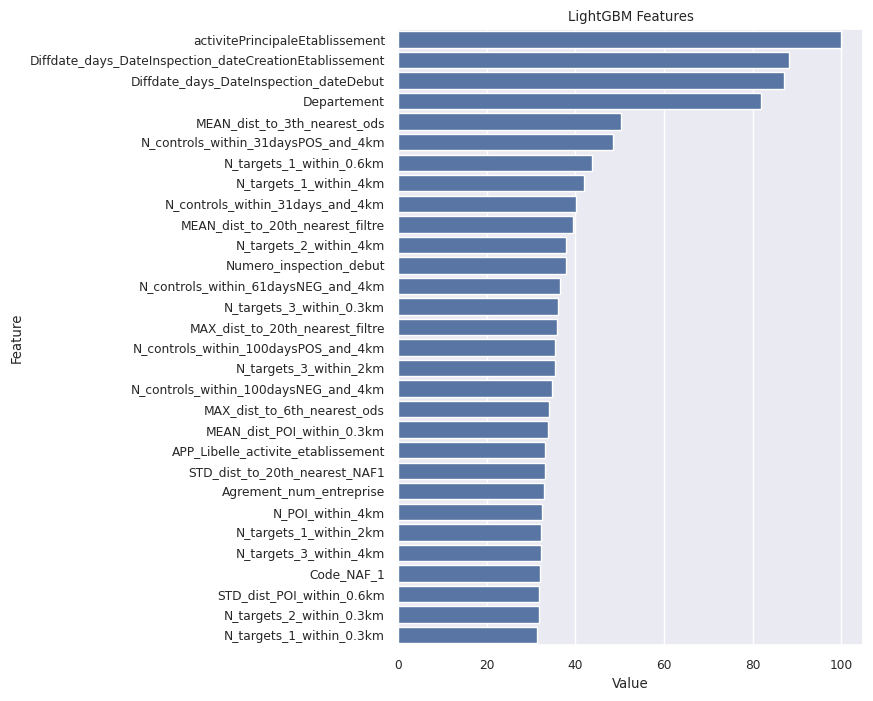

In [28]:
# Importance des variables
Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 8))
sns.barplot(x="Value", y="Feature", data=Feature_Imp.head(30))
plt.title('LightGBM Features')
plt.show()

In [29]:
# Most important features
n = 10
list(Feature_Imp.Feature.values[:n])

['activitePrincipaleEtablissement',
 'Diffdate_days_DateInspection_dateCreationEtablissement',
 'Diffdate_days_DateInspection_dateDebut',
 'Departement',
 'MEAN_dist_to_3th_nearest_ods',
 'N_controls_within_31daysPOS_and_4km',
 'N_targets_1_within_0.6km',
 'N_targets_1_within_4km',
 'N_controls_within_31days_and_4km',
 'MEAN_dist_to_20th_nearest_filtre']

In [31]:
# Less important features
n = 50
list(Feature_Imp.Feature.values[::-1][:n])

['other_y0_AGREMENTS_in_dftrain',
 'tfidf_atelier',
 'tfidf_pain',
 'tfidf_fils',
 'tfidf_mas',
 'tfidf_charcuterie',
 'tfidf_salaisons',
 'tfidf_soc',
 'tfidf_mairie',
 'flag_Entreposage de distribution de denrées alimentaires',
 'tfidf_leclerc',
 'tfidf_paris',
 'tfidf_commune',
 'tfidf_groupe',
 'tfidf_viandes',
 'tfidf_ehpad',
 'tfidf_etablissements',
 'tfidf_exploitation',
 'tfidf_maree',
 'tfidf_delices',
 'flag_Transformation de lait ou produits laitiers',
 'tfidf_king',
 'is_rayon',
 'tfidf_sushi',
 'tfidf_saveurs',
 'tfidf_eurl',
 'tfidf_donald',
 'tfidf_earl',
 'Ville',
 'tfidf_ass',
 'tfidf_chateau',
 'tfidf_market',
 'tfidf_adresse_pierre',
 'tfidf_bistrot',
 'flag_Transport de denrées alimentaires',
 'ndays_MEAN_since_past_controls',
 'flag_Métier de bouche',
 'flag_Producteur fermier',
 'N_NAF1_3_within_0.03km',
 'Days_since_next_control_to_REAL_20th_nearest',
 'tfidf_ecole',
 "flag_Chaîne d'abattage d'animaux boucherie/Gibier ongulé élevage",
 'tfidf_centre',
 'result_ne

___
___
# **Export oof and test scores**

In [38]:
# Create score
for i, i_lib in enumerate(target_classes) :
    test_df[f'pred_lgbm_final_{i_lib}'] = test_df[[f'pred_lgbm_param{num_params}_{i_lib}' for num_params in range(len(MODEL_PARAMS))]].mean(axis=1)
test_df['Synthese_eval_sanit'] = test_df[[f'pred_lgbm_final_{i}' for i in target_classes]].idxmax(axis=1).apply(lambda x : x.replace('pred_lgbm_final_', ''))
    
print(test_df.shape)

(9717, 952)


___
### **Export oof**

In [39]:
# Train
cols = ['Numero_inspection'] + [x for x in df if x not in initial_columns_df]
df[cols].to_csv('OOF/train_oof_lgbm.csv', index=False)

# Test
cols = ['Numero_inspection', 'trustii_id'] + [x for x in test_df if x not in initial_columns_test_df]
test_df[cols].to_csv('OOF/test_oof_lgbm.csv', index=False)

df[cols].head(1)

,Numero_inspection,oof_lgbm_param0_A corriger de manière urgente,oof_lgbm_param0_A améliorer,oof_lgbm_param0_Satisfaisant,oof_lgbm_param0_Très satisfaisant,oof_class_lgbm_param0,oof_lgbm_param0_0,oof_lgbm_param0_1,oof_lgbm_param0_2,oof_lgbm_param0_3,oof_lgbm_param1_A corriger de manière urgente,oof_lgbm_param1_A améliorer,oof_lgbm_param1_Satisfaisant,oof_lgbm_param1_Très satisfaisant,oof_class_lgbm_param1,oof_lgbm_param1_0,oof_lgbm_param1_1,oof_lgbm_param1_2,oof_lgbm_param1_3,oof_lgbm_param2_A corriger de manière urgente,oof_lgbm_param2_A améliorer,oof_lgbm_param2_Satisfaisant,oof_lgbm_param2_Très satisfaisant,oof_class_lgbm_param2,oof_lgbm_param2_0,oof_lgbm_param2_1,oof_lgbm_param2_2,oof_lgbm_param2_3,oof_lgbm_param3_A corriger de manière urgente,oof_lgbm_param3_A améliorer,oof_lgbm_param3_Satisfaisant,oof_lgbm_param3_Très satisfaisant,oof_class_lgbm_param3,oof_lgbm_param3_0,oof_lgbm_param3_1,oof_lgbm_param3_2,oof_lgbm_param3_3,oof_lgbm_param4_A corriger de manière urgente,oof_lgbm_param4_A améliorer,oof_lgbm_param4_Satisfaisant,oof_lgbm_param4_Très satisfaisant,oof_class_lgbm_param4,oof_lgbm_param4_0,oof_lgbm_param4_1,oof_lgbm_param4_2,oof_lgbm_param4_3,oof_lgbm_param5_A corriger de manière urgente,oof_lgbm_param5_A améliorer,oof_lgbm_param5_Satisfaisant,oof_lgbm_param5_Très satisfaisant,oof_class_lgbm_param5,oof_lgbm_param5_0,oof_lgbm_param5_1,oof_lgbm_param5_2,oof_lgbm_param5_3,pred_lgbm_final_A corriger de manière urgente,pred_lgbm_final_A améliorer,pred_lgbm_final_Satisfaisant,pred_lgbm_final_Très satisfaisant,oof_final_lgbm
0,23-110093-1,0,0,0,0,2,0.00025,0.002126,0.977534,0.02009,0,0,0,0,2,0.000288,0.003159,0.972857,0.023696,0,0,0,0,2,0.000643,0.004478,0.966347,0.028531,0,0,0,0,2,0.000199,0.002751,0.971118,0.025931,0,0,0,0,2,0.000555,0.004122,0.972977,0.022347,0,0,0,0,2,0.00034,0.00415,0.963529,0.031981,0.000379,0.003464,0.970727,0.025429,Satisfaisant
